# HPLC Denoiser

Purpose: Generate an algorithm that I can run to take away noise from HPLC traces so I can find true areas of peaks 

Steps 1: Generate a method to generate synthetic data 

Steps 2: Generate a method to add different types of noise to that data. 

Steps 3: Error Tolerances. A). How much noise can I add and still get an accurate peak area? B). How close can two peaks be before I lose accuracy?

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
pd.options.mode.chained_assignment = None 
import seaborn as sns 
import math
import random
from scipy.integrate import simps
from sklearn.manifold import TSNE
from scipy.integrate import simps
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from statannot import add_stat_annotation
import scipy.signal
from scipy.stats import exponnorm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from lmfit.models import GaussianModel
from lmfit.models import GaussianModel,ExponentialGaussianModel,SkewedGaussianModel,VoigtModel,LorentzianModel,LognormalModel
from scipy.signal import savgol_filter, find_peaks, find_peaks_cwt
from scipy import sparse
from scipy.sparse.linalg import spsolve
import scipy
import pybaselines
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["font.family"] = "Arial"
sns.set(font_scale=1)
sns.set_style("white")

In [2]:
def model_n_expgaus(x,y,number_peaks,peak_locations,peak_heights,graph=False,peakz=None):
    """
    Inputs: x and y axises to be fitted, the number of peaks to create and the approximate peak locations 
    Outputs: Array of tuples (peak location, peak area)
    Prints: Summary graphs showing initial and final fit, and showing the locations of gaussian components 
    """
  
    #goes from max to min number of peaks, finds bic, removes smallest peak, repeat 
    model=''
    for n in range(0,number_peaks):
        gaus=ExponentialGaussianModel(prefix='p'+str(n)+"_")
        #addition of first model for first peak
        if model=='':
            model=gaus
            pars=gaus.make_params(prefix='p'+str(n)+"_")
            #peak locations can vary by 1 min 
            pars['p'+str(n)+'_center'].set(value=peak_locations[n],min=peak_locations[n]-0.5,max=peak_locations[n]+0.5)
            #sigma can only be so large and small 
            pars['p'+str(n)+'_sigma'].set(value=0.05, min=0.01,max=2)
            #amplitude can only be so small to be a real peak 
            pars['p'+str(n)+'_amplitude'].set(value=peak_heights[n], min=0.01*peak_heights[n],max=peak_heights[n]*1.1)
            pars['p'+str(n)+'_gamma'].set(value=2,max=5,min=0.01)
        #all subsequent peaks    
        else:
            model+=gaus
            pars.update(gaus.make_params(prefix='p'+str(n)+"_"))
            pars['p'+str(n)+'_center'].set(value=peak_locations[n],min=peak_locations[n]-0.5,max=peak_locations[n]+0.5)
            pars['p'+str(n)+'_sigma'].set(value=0.05, min=0.01,max=2)
            pars['p'+str(n)+'_amplitude'].set(value=peak_heights[n], min=0.01*peak_heights[n],max=peak_heights[n]*1.1)
            pars['p'+str(n)+'_gamma'].set(value=2,max=5,min=0.01)
    #Uses gradient descent to best fit model 
    try:
        result = model.fit(y, pars, x=x)
    #print(result.fit_report())
    except AttributeError:
        return None

    # plot results

    #intial fit 
    init = model.eval(pars, x=x)
    #to get best fit 
    out = model.fit(y, pars, x=x)


 







    comps=out.eval_components(x=x) 
    if graph:
        fig, axes = plt.subplots(3, 1, figsize=(10,15))
        plt.style.use("fast")

        #plots underlying data
        axes[0].plot(x, y)
        #plots initial fit in orange with dashed line 
        axes[0].plot(x, init, '--', label='initial fit')
        #plots best fit in green with solid line 
        axes[0].plot(x, out.best_fit, '-', label='best fit')
        axes[1].plot(x, out.best_fit, '-', label='best fit',color='k')
        axes[0].legend()

        #find the components of the best fit curve 
        #plots underlying data 
        plt.style.use("fast")
        axes[1].plot(x, y,color='blue')
        areas=[]
    #plots each peak 
    areas=[]
    colors=['#176E9D','#C2882B','#128B6A']
    for n in range(0,number_peaks):
        if graph:
            axes[1].plot(x, comps['p'+str(n)+"_"], '--', label='Gaussian component '+str(n),color=colors[n])
            axes[1].fill_between(x, comps['p'+str(n)+"_"].min(), comps['p'+str(n)+"_"], alpha=0.5,color=colors[n]) 
            #adds peak location on the actual output graph 
            #axes[2].plot(x, comps['p'+str(n)+"_"], '--', label='Gaussian component '+str(n),color=colors[n])
            axes[2].fill_between(x, comps['p'+str(n)+"_"].min(), comps['p'+str(n)+"_"], alpha=0.5,color=colors[n]) 
  
            if n==0:
                axes[2].plot(x,peakz[n],color='k')
            elif n==1:
                axes[2].plot(x,peakz[n],color='r')
            else:
                axes[2].plot(x,peakz[n],color='orange')
            #axes[1].text(out.params['p'+str(n)"_center"].value, out.params['p'+str(n)+"_amplitude"].value+1, str(out.params['p'+str(n)+"_center"].value)[0:5], fontsize=8,horizontalalignment='center')
        #calculates the area which is amplitude(SD)/(1/sqrt(2*pi))
        area=sum(comps['p'+str(n)+"_"])*0.01
        error=0
        
        """
        for a,b in zip(peakz[n],comps['p'+str(n)+"_"]):
           error+=(a-b)*(a-b)
        """
        rmse=np.sqrt(error/(len(y)))
        
        center=out.params['p'+str(n)+"_center"].value
        #print(error)
        areas.append([center,area,rmse])
    
        #axes[1].legend()
    
   # plt.show()
    return(areas)

def find_locations_peaks(data,peak_prominence_cutoff,height_cutoff,graph=False,shoulder=False, shoulder_cutoffs=None):
    """
    Inputs: Data for the HPLC trace, prominence cut off for when peaks should be accepted 
    Outputs: Approximate Peak locations 
    """
    #Use peaks from the first derivative to find putative peak locations 
    #Can we improve on this? (Use 0th derivative to find real peaks and first derivative to find shoulders)
    
    #Finds time averaged derivative
    data.loc[:, 'Smoothed']=savgol_filter(data.loc[:,"Value"], window_length=31, polyorder=3, deriv=0)
    data.loc[:, 'Time Ave']=savgol_filter(data.loc[:,"Value"], window_length=31, polyorder=3, deriv=1)
    #data.loc[:, 'Time Ave']+=min(data.loc[:, 'Time Ave'])
    if graph:
        fig,ax=plt.subplots(2,1,figsize=(15,10))
        #plots derivative 
        sns.lineplot(x=data['Time'], y=data['Smoothed'], label='Smoothed',ax=ax[0])
    data["Inverse Smoothed"]=data.loc[:,'Smoothed']*-1+max(data.loc[:, 'Smoothed'])
    data["Inverse Time Ave"]=data.loc[:,'Time Ave']*-1+max(data.loc[:, 'Time Ave'])
    data["Moved Time Ave"]=data.loc[:,'Time Ave']+abs(min(data.loc[:, 'Time Ave']))
    
    if graph:
        sns.lineplot(x=data['Time'], y=data['Time Ave'], label='Time Averaged First Derivative',ax=ax[1])
        sns.lineplot(x=data['Time'], y=data['Inverse Time Ave'], label='Inverse Time Averaged First Derivative',ax=ax[1])
    #finds peaks from the time averaged derivative. These are really inflection points not actually peaks, but this
    #method will correctly identify shoulders
    #finds real peaks 
    peaks = find_peaks(data['Smoothed'],prominence=peak_prominence_cutoff,height=height_cutoff)[0]
    peaks2 = find_peaks(data['Moved Time Ave'],prominence=peak_prominence_cutoff/5,height=height_cutoff/5)[0]
    valleys = find_peaks(data['Inverse Smoothed'],prominence=peak_prominence_cutoff,height=height_cutoff)[0]
    valleys2 = find_peaks(data['Inverse Time Ave'],prominence=peak_prominence_cutoff/5,height=height_cutoff/5)[0]
    shoulder_times=[]
    for potential_shoulder in peaks2: 

        if data["Time Ave"].values[potential_shoulder]>=0:
            pass 
        else:
            shoulder_times.append(potential_shoulder)
    for potential_shoulder in valleys2: 

        if data["Time Ave"].values[potential_shoulder]<=0:
            pass 
        else:
            shoulder_times.append(potential_shoulder)
    #plots IDed peaks on the first derivative plot (or normal plot)
    if graph:
        sns.scatterplot(x=data["Time"].values[peaks], y=data["Smoothed"].values[peaks], s = 55,
                 label = 'Peak Centers',ax=ax[0])
        sns.scatterplot(x=data["Time"].values[valleys], y=data["Smoothed"].values[valleys], s = 55,
                 label = 'Valleys',ax=ax[0])
        """
        sns.scatterplot(x=data["Time"].values[shoulder_times], y=data["Smoothed"].values[shoulder_times], s = 55,
                 label = 'Peak Shoulders',ax=ax[0])
        
        sns.scatterplot(x=data["Time"].values[valleys2], y=data["Time Ave"].values[valleys2], s = 55,
                 label = 'Inverse Time Ave',ax=ax[1])
        sns.scatterplot(x=data["Time"].values[peaks2], y=data["Time Ave"].values[peaks2], s = 55,
                 label = 'Peak Shoulders',ax=ax[1])
        """
        plt.show()
    
    times=data["Time"].values[peaks]
    valley_times=[0]
    for a in valleys:
        valley_times.append(data["Time"].values[a])
    heights=data["Value"].values[peaks]
    if shoulder:

        times=np.append(times,data["Time"].values[shoulder_times],axis=0)
        heights=np.append(heights,data["Value"].values[shoulder_times],axis=0)
    valley_times.append(20)  
    #converts reference peaks into the time domain (rather than index )
    print(valley_times)
    return times,heights,valley_times
def find_peak_areas(single_rep,sample_name,start,end,canonical_peaks=None,graph=False,shoulder=False,comparisons=False,
                   peak1=None,peak2=None,peak3=None):
    #reduces the dataframe to a single replicate 
    #finds peaks 
    if canonical_peaks is None:
        reference_peak_list,heights,valleys=find_locations_peaks(single_rep.loc[(single_rep['Time']>=start) & (single_rep['Time']<end)],0.1,1,graph=graph,shoulder=shoulder)
    else:
        reference_peak_list,heights,valleys=canonical_peaks[0],canonical_peaks[1],canonical_peaks[2]
    #x and y for gaussian modeling 
    x=single_rep.loc[(single_rep['Time']>=start) & (single_rep['Time']<=end)]['Time']
    y=single_rep.loc[(single_rep['Time']>=start) & (single_rep['Time']<=end)]['Value']
    areas=model_n_expgaus(x,y,len(reference_peak_list),reference_peak_list,heights,graph=graph,peakz=[peak1,peak2,peak3])
    return areas


In [3]:
#generate synthetic data
x =np.arange(0,107.5,0.01)
from scipy.stats import exponnorm

#randomly 
def _ngaussian_exp(x,amps,cens,sigmas,gammas,noise=None,noiseamp=0,graph=False):
    func=0
    fn=0
    area=[]
    for n in range(0,len(amps)):
        fn+=amps[n]*exponnorm.pdf(x, gammas[n],scale=sigmas[n],loc=cens[n])
        area.append(amps[n])
    if graph:
        fig,ax=plt.subplots(1,1,figsize=(15,5))
        ax.plot(x,fn)
    if noise=='Normal':
        fn+=np.random.normal(size=len(x), scale=noiseamp*min(amps))
    if noise=='Normal Slanted':
        fn+=np.random.normal(size=len(x), scale=noiseamp*min(amps))
        fn+=5*x
    if graph:
        fig,ax2=plt.subplots(1,1,figsize=(15,5))
        ax2.plot(x,fn)

    return area,fn
def low_pass_filter(data, band_limit, sampling_rate) -> np.ndarray:
    # translate bandlimit from Hz to dataindex according to sampling rate and data size
     cutoff_index = int(band_limit * data.size / sampling_rate)
     F = np.fft.rfft(data)
     F[cutoff_index + 1:] = 0
    
     return np.fft.irfft(F, n=data.size).real
def remove_noise(data, band_limit,lamba,smoothing, sampling_rate=500):
    """
    Inputs: 
    Data: numpy array with signal 
    Band-limit: Frequency cutoff for FFT
    Sampling-rate: Max Frequency that's measured (500/s for our machine)
    lamba: smoothing function for
    """
    k=pybaselines.whittaker.psalsa(data,lam=lamba)[0]
    data=data-k
    z=low_pass_filter(data,band_limit,sampling_rate)
    z=np.convolve(z, np.ones(smoothing)/smoothing, mode='same')
    return z

# Figure 5A

In [18]:
#generate one peak with increasing amounts of noise and compare error rates 
error_list=[]

for amp in [0,0.01,0.05,0.1,0.2,0.4,0.8]:
    print(amp)
    for i in range(0,100):
        amps=[]
        gammas=[]
        sigmas=[]
        center=[0]
        for y in range(0,1): 
            amps.append(random.uniform(1,5))
            gammas.append(random.uniform(2.9,3))
            sigmas.append(random.uniform(0.1,0.2))
            center.append(random.uniform(max(center)+0.5,max(center)+1.5))
        x =np.arange(0,20,0.01)
        areas,y=_ngaussian_exp(x,amps,center[1:],sigmas,gammas,noise='Normal',noiseamp=amp)
        #k=pybaselines.whittaker.psalsa(y,lam=1e10)[0]
        y=y
        z=low_pass_filter(y,2000,500)
        z=np.convolve(z, np.ones(20)/20, mode='same')
        df = pd.DataFrame()
        df2 = pd.DataFrame()
        df["Time"]=x
        df["Value"]=z
        df2["Time"]=x
        df2["Value"]=y

        area=find_peak_areas(df,"sample",0,20,canonical_peaks=[center[1:],amps,0],graph=False,shoulder=False)
        print(area)
        if area!=None:
            
            algo=area[0][1]
            ground_truth=amps[0]
            integration=df2[(df2.Time>=0) & (df2.Time<=3.5)]['Value'].sum()*0.01
            error_list.append({"Noise":amp,"Error Percentage":abs(algo-ground_truth)/ground_truth*100, "Analysis Type": "PeakClimber"})
            error_list.append({"Noise":amp,"Error Percentage":abs(integration-ground_truth)/ground_truth*100, "Analysis Type": "Valley-to-Valley"})

     
error_df=pd.DataFrame(error_list)

    

0
[[1.0633849999653087, 3.08188514764603, 0.0]]
[[1.128625183510596, 4.780878829054501, 0.0]]
[[1.433476253052301, 4.60003489151977, 0.0]]
[[0.5243404705473494, 3.2181491221857144, 0.0]]
[[1.5049788558331778, 2.2800147256284995, 0.0]]
[[1.5002537169102295, 3.2095032298221713, 0.0]]
[[0.830632186428381, 3.2946830351295735, 0.0]]
[[1.2822921926011723, 1.708202952820022, 0.0]]
[[1.0583130963640954, 2.741660875342558, 0.0]]
[[0.9117385022861172, 1.0978674774250465, 0.0]]
[[1.1019600020916849, 3.6355030678470026, 0.0]]
[[0.7855085212612299, 4.326124409694226, 0.0]]
[[1.217986406203661, 4.298780435688512, 0.0]]
[[0.6552558486151204, 3.1056706543662473, 0.0]]
[[1.4305954654385116, 1.5770068638480763, 0.0]]
[[0.8918446104645598, 4.11855490043091, 0.0]]
[[0.6294191920919951, 4.440789846035596, 0.0]]
[[1.3173202673023146, 4.649548079461184, 0.0]]
[[1.3712099735654504, 4.592814696334706, 0.0]]
[[1.2765102553468703, 1.416714127877196, 0.0]]
[[1.4008676602232981, 2.317665082526838, 0.0]]
[[0.645878

[[0.8514832132349524, 4.272653320348449, 0.0]]
[[0.5951784165588145, 2.688721409194879, 0.0]]
[[0.7821349258676391, 2.1019024660540437, 0.0]]
[[0.8077957004882839, 3.717553784832398, 0.0]]
[[0.9255836124841608, 4.638822759652818, 0.0]]
[[1.0706351797695557, 1.2890126568952582, 0.0]]
[[0.5275909991734544, 2.671216046356112, 0.0]]
[[0.9608364679540509, 1.4858503321426224, 0.0]]
[[1.490518933260818, 4.391439332290356, 0.0]]
[[1.2307012334776681, 3.124441227908272, 0.0]]
[[1.1312045195559706, 1.2294001752705483, 0.0]]
[[0.942691081770715, 1.8639544071323113, 0.0]]
[[0.8693213662916776, 3.5310274489324525, 0.0]]
[[1.0682963092180815, 3.170911683328875, 0.0]]
[[1.0526247890745173, 2.1254591411731285, 0.0]]
[[0.7749505414187827, 1.7673200600817123, 0.0]]
0.05
[[0.996527289872742, 4.354094643987207, 0.0]]
[[0.7546082704848974, 3.66371129730276, 0.0]]
[[1.0782860822747389, 4.151503825371019, 0.0]]
[[0.5141588528222873, 2.03551703419547, 0.0]]
[[1.2145016506372641, 3.3525930013437626, 0.0]]
[[1.

[[1.0378061944616244, 1.9615485345501826, 0.0]]
[[1.440387478641727, 4.88955081274089, 0.0]]
[[0.8768466618825828, 4.462245437238468, 0.0]]
[[0.5386001539731905, 1.7030610348090502, 0.0]]
[[1.3582238881121407, 2.4977174776065607, 0.0]]
[[0.5087518455664252, 1.7909441200370577, 0.0]]
[[0.6898124018629013, 2.0761989487238806, 0.0]]
[[1.2431261800336624, 3.7008343647737485, 0.0]]
[[0.6200922905297761, 2.5766260825252862, 0.0]]
[[1.04088846289513, 1.4209499755233261, 0.0]]
[[0.784348117639537, 2.3393193256116813, 0.0]]
[[0.7035924264914082, 3.946300815600058, 0.0]]
[[1.4790307569962993, 2.644136389759558, 0.0]]
[[1.1916098646160882, 2.9982424718656295, 0.0]]
[[0.8492477685337224, 3.040674730198004, 0.0]]
[[0.7969375140489832, 2.7399903646612795, 0.0]]
[[1.078921193063539, 3.903497093179327, 0.0]]
[[1.1999107601809924, 3.6920850642003633, 0.0]]
[[1.3585622886410755, 4.038641491654186, 0.0]]
[[0.5520021877288825, 4.4068297474854194, 0.0]]
[[1.0438589040270396, 1.4150617416959872, 0.0]]
[[1.0

[[0.7065629344573469, 1.26613589361355, 0.0]]
[[1.048156136039759, 2.7533592323080316, 0.0]]
[[1.267410167368514, 3.0216230836250775, 0.0]]
[[1.51769473772318, 2.748798274765799, 0.0]]
[[0.8835527050034935, 2.178523858222909, 0.0]]
[[1.3360736906422468, 1.1508687480189561, 0.0]]
[[1.1731747618161799, 2.5040853149553817, 0.0]]
[[0.5257080083366296, 5.188177517210439, 0.0]]
[[0.9508287852080157, 4.8263820442893985, 0.0]]
[[1.0091221340597243, 2.2881846823863627, 0.0]]
[[0.8361828308477164, 1.5859501481414962, 0.0]]
[[0.5865966359122342, 3.0841901103689295, 0.0]]
[[1.4329167947234316, 3.53597450238361, 0.0]]
[[0.8885514350173069, 4.574232964825182, 0.0]]
[[0.5941818369999643, 1.687311354101317, 0.0]]
[[0.9171782808338877, 1.14312825361557, 0.0]]
[[0.6462645319808451, 3.9970370725002726, 0.0]]
[[1.4217728707686088, 3.6094824949741624, 0.0]]
[[1.2501193095309846, 4.200615322867088, 0.0]]
[[1.1366811191332602, 3.5073544855004775, 0.0]]
[[1.0618216866711587, 1.9526312602605893, 0.0]]
[[1.4650

In [19]:
error_df=pd.DataFrame(error_list)

(-0.5, 20.0)

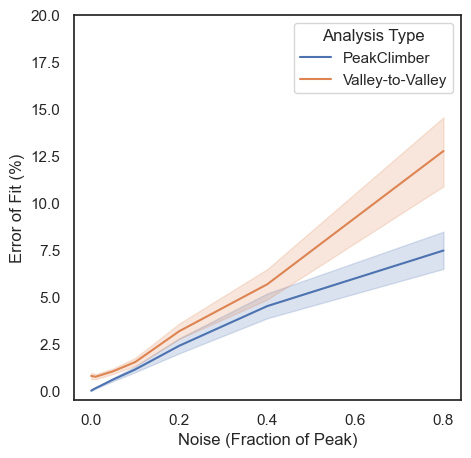

In [21]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
sns.lineplot(ax=ax,data=error_df,x="Noise",y="Error Percentage",hue="Analysis Type")
ax.set_ylabel("Error of Fit (%)")
ax.set_xlabel("Noise (Fraction of Peak)")
ax.set_ylim(-0.5,20)

# Figure 1 B Schematic

[0, 0.77, 1.43, 4.09, 20]
[1.05 1.71 4.45] [0, 0.77, 1.43, 4.09, 20]


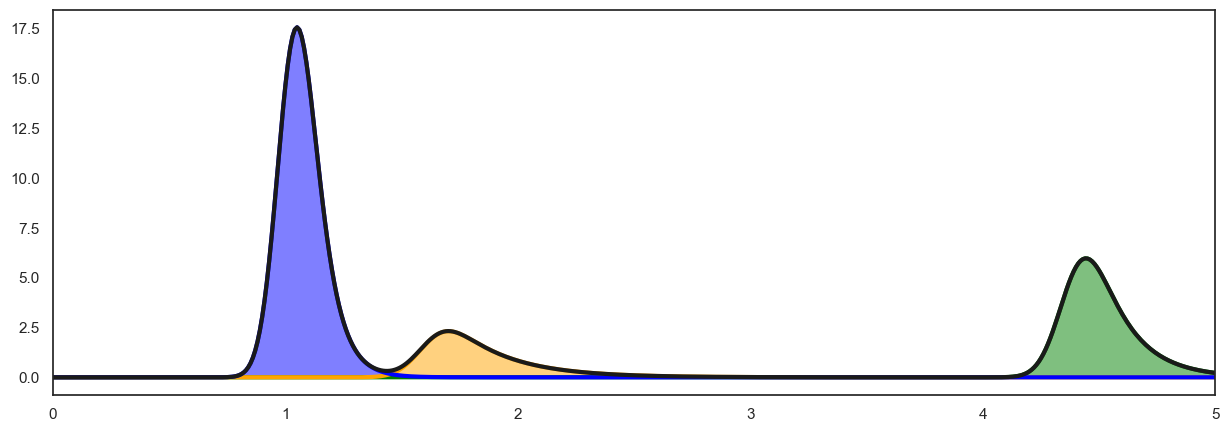

In [13]:
#figure 1 
error_list=[]
for n in range(0,1):
        amps=[]
        gammas=[]
        sigmas=[]
        center=[1]
        #Peak 1,2,3
        amps.append(4)
        amps.append(1)
        amps.append(2)
        gammas.append(random.uniform(1,3))
        gammas.append(random.uniform(1,3))
        gammas.append(random.uniform(1,3))
        sigmas.append(random.uniform(0.05,0.1))
        sigmas.append(random.uniform(0.05,0.1))
        sigmas.append(random.uniform(0.05,0.1))
        center.append(max(center)+random.uniform(0.5,0.6))
        center.append(max(center)+random.uniform(2.7,2.8))
        x =np.arange(0,40,0.01)
        areas,y=_ngaussian_exp(x,amps,center,sigmas,gammas,noise='None')
        #k=pybaselines.whittaker.psalsa(y,lam=1e11)[0]
        #y=y-k
        #z=low_pass_filter(y,2000,500)
        #z=np.convolve(z, np.ones(10)/10, mode='same')
        """
        fig,ax=plt.subplots(1,1,figsize=(15,5))
        ax.plot(x,z)
        ax.plot(x,y)
        """
        df = pd.DataFrame()
        df["Time"]=x
        df["Value"]=y
        if n<5:
            graph=True
        else:
            graph=False
        centers,heights,valleys=find_locations_peaks(df,0.01,1,graph=False,shoulder=False, shoulder_cutoffs=None)

        print(centers,valleys)
        if len(valleys)>4:
            valleys=valleys[1:]
        _,y1=_ngaussian_exp(x,[amps[0]],[center[0]],[sigmas[0]],[gammas[0]],noise='None')
        y_1=y[:int(valleys[1]*100)]
        z1=np.zeros(4000-int(valleys[1]*100))
        y_1=np.concatenate((y_1,z1))

        _,y2=_ngaussian_exp(x,[amps[1]],[center[1]],[sigmas[1]],[gammas[1]],noise='None')
        y_2=y[int(valleys[1]*100):int(valleys[2]*100)]
        z1=np.zeros(int(valleys[1]*100))
        z2=np.zeros(4000-int(valleys[2]*100))
        y_2=np.concatenate((z1,y_2,z2))
        
        _,y3=_ngaussian_exp(x,[amps[2]],[center[2]],[sigmas[2]],[gammas[2]],noise='None')
        y_3=y[int(valleys[2]*100):]
        z3=np.zeros(int(valleys[2]*100))
        y_3=np.concatenate((z3,y_3))
        y1_error=0
        for i in range(len(y)):
            y1_error+=(y_1[i]-y1[i])*(y_1[i]-y1[i])
        y1_error=math.sqrt(y1_error/(valleys[1]*100-valleys[0]*100))
        
        y2_error=0
        for i in range(len(y)):
            y2_error+=(y_2[i]-y2[i])*(y_2[i]-y2[i])
        y2_error=math.sqrt(y2_error/(len(y)))
        
        y3_error=0
        for i in range(len(y)):
            y3_error+=(y_3[i]-y3[i])*(y_3[i]-y3[i])
        y3_error=math.sqrt(y3_error/(len(y)))
        
        fig,ax=plt.subplots(1,1,figsize=(15,5))
        ax.fill_between(x,y_3,color="green",alpha=0.5)
        ax.fill_between(x,y_1,color='blue',alpha=0.5)
        ax.fill_between(x,y_2,color='orange',alpha=0.5)
        ax.plot(x,y3,color="green",linewidth=3)
        ax.plot(x,y2,color="orange",linewidth=3)
        ax.plot(x,y1,color="blue",linewidth=3)
        ax.plot(x,y,color="k",linewidth=3)
        
        #ax.plot(x,y_3,color='blue')
        ax.set(xlim=(0,5))
        error_list.append({"Peak Number":1,"RMSE":y1_error})
        error_list.append({"Peak Number":2,"RMSE":y2_error})
        error_list.append({"Peak Number":3,"RMSE":y3_error})


# Figure 1 B quantification

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1 v.s. 2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.923e-04 U_stat=9.900e+01
1 v.s. 3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.653e-04 U_stat=1.000e+02


(<Axes: xlabel='Peak Number', ylabel='Fit Error(RMSE)'>,
  <statannot.StatResult.StatResult at 0x7fe0c20e13a0>])

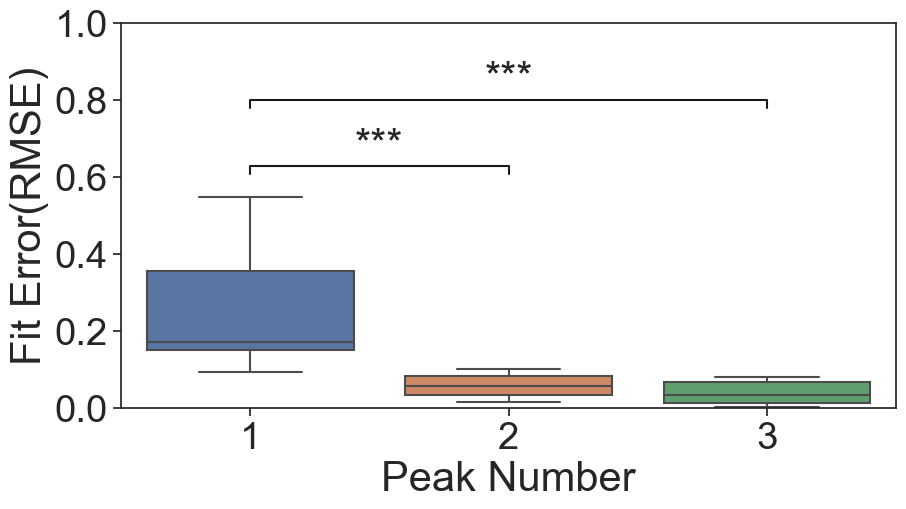

In [31]:
dataframe=pd.DataFrame(error_list)
plt.rcParams["font.family"] = "Arial"
sns.set(font_scale=2.5)
sns.set_style("ticks")

fig,ax=plt.subplots(1,1,figsize=(10,5))
sns.boxplot(data=dataframe,x="Peak Number",y="RMSE",ax=ax)

ax.set_ylim(0,1)
ax.set_ylabel("Fit Error(RMSE)")

box_pairs=[
    ((1),(2)),
    ((1),(3)),
   


    
]
add_stat_annotation(ax=ax,data=dataframe, x="Peak Number", y='RMSE',
                    box_pairs=box_pairs,
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2,color='k')
